# =====================================
#  4A - L1 Introduction to "features"
# =====================================

## Image Point Matching Problem

- Suppose I have two images related by some transformation Or have two images of the same object in different positions.
- How to find the transformation of image 1 that would align it with image 2


<br />
<figure>
  <img src="imgs/transformation.png" />
  <center><figcaption>Fig.1(a): Transformation</figcaption></center>
</figure>

### We want Local$ ^{(1)}$ Features$ ^{(2)}$

*Not machine learning features, but things that we compute about little region or spots*

- Goal: Find point in an image that can be:
    - Found in other images
    - Found precisely - well localized
    - Found reliably - well matched
    
Why?

- Want to compute a fundamental matrix to recover geometry
- Robotics/vision: See how a bunch of points move from one frame to another. Allows computation of how camera moved -> depth -> moving objects
- Build a panorama


<br />
<figure>
  <img src="imgs/building_panorama.gif" />
  <center><figcaption>Fig.1(b): Building panorama</figcaption></center>
</figure>



## Matching with Features

- Detect features (features points) in both images
- Match features - find corresponding pairs
- Use these pairs to align images

<br />
<figure>
  <img src="imgs/detecting_points.png" />
  <center><figcaption>Fig.2(a): Similar Points</figcaption></center>
</figure>
<figure>
  <img src="imgs/detecting_points2.png" />
  <center><figcaption>Fig.2(b): Result</figcaption></center>
</figure>

- Problem 1:
    - Detec the same point independently in both
<br />
<br />
<figure>
  <img src="imgs/detecting_points3.png" />
  <center><figcaption>Fig.2 (c): No chance to match</figcaption></center>
</figure>

<center><font color="green">We need a repeatable detector</font></center>


- Problem 2:
    - For each point correctly recognize the corresponding one
<br />
<br />
<figure>
  <img src="imgs/detecting_points3.png" />
  <center><figcaption>Fig.2 (d): Which point is which</figcaption></center>
</figure>

<center><font color="green">We need a reliable and distinctive descriptor</font></center>


### More motivation...

- Feature points are used also for:
    - Image alignment (e.g. homography or fundamental matrix)
    - 3D reconstruction
    - Mortion tracking
    - Object recognition
    - Indexing and database retrieval
    - Robot navigation
    - ... Other

<font color="blue">**Quize**</font>

<figure>
  <img src="imgs/good_feature_quiz.png" />
  <center><figcaption>Good feature quize</figcaption></center>
</figure>

## Characteristics of Good Features

### Repeatability/Precision
- The same feature can be found in several images despite geometric and photometric transformation

### Saliency/Matchability
- Each feature has a distinctive description

### Compactness and efficiency
- Many fewer features than image pixels

### Locality
- A feature occupies a relatively small area of the image; robust to clutter and occlusion


In [9]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import PIL
from io import BytesIO
from IPython.display import clear_output, Image as NoteImage, display
def imshow(im,fmt='jpeg'):
    #a = np.uint8(np.clip(im, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(im).save(f, fmt)
    display(NoteImage(data=f.getvalue()))
def imread(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
def red(im):
    return im[:,:,0]
def green(im):
    return im[:,:,1]
def blue(im):
    return im[:,:,2]
def gray(im):
    return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
def square(img,center,size,color=(0,255,0)):
    y,x = center
    leftUpCorner = (x-size,y-size)
    rightDownCorner = (x+size,y+size)
    cv2.rectangle(img,leftUpCorner,rightDownCorner,color,3)
def normalize_img(s):
    start = 0
    end = 255
    width = end - start
    res = (s - s.min())/(s.max() - s.min()) * width + start
    return res.astype(np.uint8)
def line(img,x):
    cv2.line(img,(0,x),(img.shape[1],x),(255,0,0),3) 
def mse(imageA, imageB):
        # the 'Mean Squared Error' between the two images is the
        # sum of the squared difference between the two images;
        # NOTE: the two images must have the same dimension
        err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
        err /= float(imageA.shape[0] * imageA.shape[1])
        # return the MSE, the lower the error, the more "similar"
        # the two images are
        return err
def random_color():
    color = list(np.random.choice(range(256), size=3))
    return (int(color[0]),int(color[1]),int(color[2]))

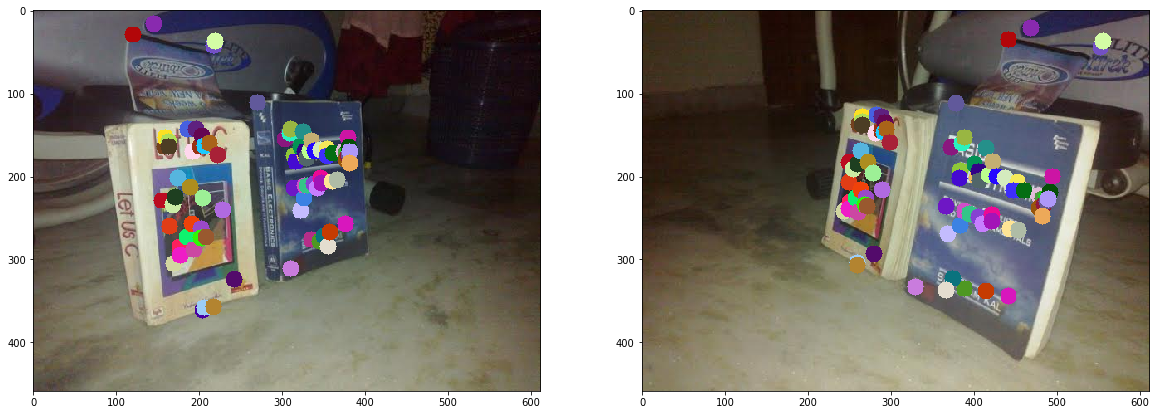

In [2]:
import numpy as np


img1 = imread('imgs/left.jpg') #queryimage # left image
img2 = imread('imgs/right.jpg') #trainimage # right image

gimg1=red(img1)
gimg2=red(img2)

sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(gimg1,None)
kp2, des2 = sift.detectAndCompute(gimg2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

for p1,p2 in zip(pts1,pts2):
    c = random_color()
    cv2.circle(img1,(int(p1[0]),int(p1[1])),10,c,-11)
    cv2.circle(img2,(int(p2[0]),int(p2[1])),10,c,-11)

# img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
fig = plt.gcf()
fig.set_size_inches((20,15))
plt.subplot(121),plt.imshow(img1)
plt.subplot(122),plt.imshow(img2)
plt.show()



# =====================================
#  4A - L2 Finding corners
# =====================================

## Corner Detection

<br />
<figure>
  <img src="imgs/corner_detection.png" />
  <center><figcaption>Fig.3: Corner detection basic idea</figcaption></center>
</figure>

## Haris Corners

### Mathematics

Change in appearance for the shift [u,v]:

$$E(u,v)=\sum_{x,y}w(x,y)[I(x + u,y+v)-I(x,y)]^2$$

$I$: Intensity image
$u,v$: are small shifts
$w$: window function

**Window function w(x,y) can be 1 in window, 0 outside or Gaussian**


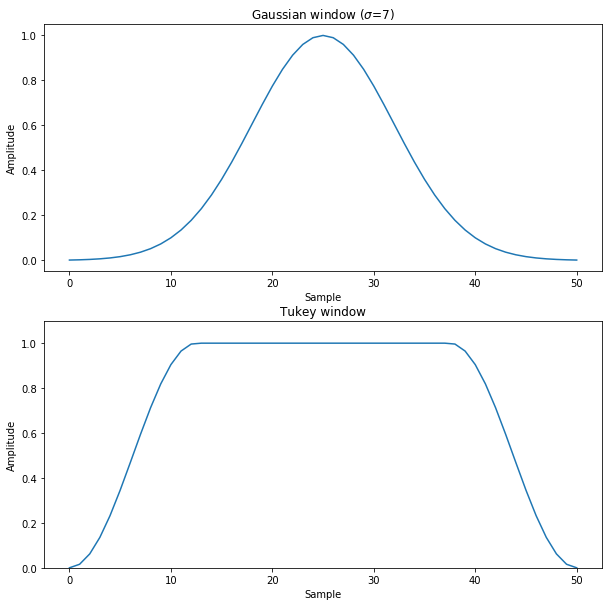

In [3]:
from scipy import signal
from scipy.fftpack import fft, fftshift
import matplotlib.pyplot as plt

window = signal.gaussian(51, std=7)
ax1 = plt.subplot(211)
ax1.plot(window)
ax1.set_title(r"Gaussian window ($\sigma$=7)")
ax1.set_ylabel("Amplitude")
ax1.set_xlabel("Sample")

window = signal.tukey(51)
ax2 = plt.subplot(212)
ax2.plot(window)
ax2.set_title("Tukey window")
ax2.set_ylabel("Amplitude")
ax2.set_xlabel("Sample")
ax2.set_ylim([0, 1.1])

fig = plt.gcf()
fig.set_size_inches((10,10))

## Harris Corners Illustrated

Explanation in the lecture video

<br />
<figure>
  <img src="imgs/harris_corner.png" />
  <center><figcaption>Fig.4: Energy Equation </figcaption></center>
</figure>

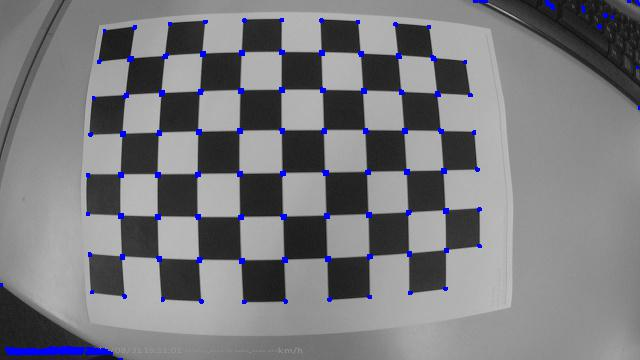

In [4]:
filename = 'imgs/chess.jpg'
img = imread(filename)
gimg = gray(img)
gimg = np.float32(gimg)
dst = cv2.cornerHarris(gimg,2,3,0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

imshow(img)

# 🤴 <font color='red'>Lets try it on the King Messi</font> 🤴

In [80]:
def calculate_haris_corner(img,show=True):
    if type(img) == str:
        img = imread(img)
    gimg = gray(img)
    gimg = np.float32(gimg)
    dst = cv2.cornerHarris(gimg,2,3,0.04)

    #result is dilated for marking the corners, not important
    dst = cv2.dilate(dst,None)

    # Threshold for an optimal value, it may vary depending on the image.
    img[dst>0.01*dst.max()]=[0,0,255]
    if show:
        imshow(img)
    return np.argwhere(dst>0.01*dst.max())

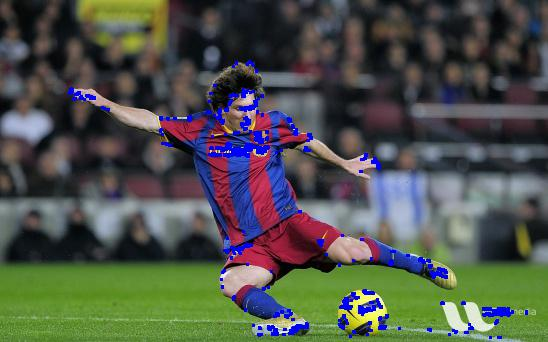

array([[ 60, 248],
       [ 60, 249],
       [ 60, 250],
       ...,
       [338, 499],
       [338, 500],
       [338, 501]])

In [69]:
calculate_haris_corner("imgs/messi.jpg")

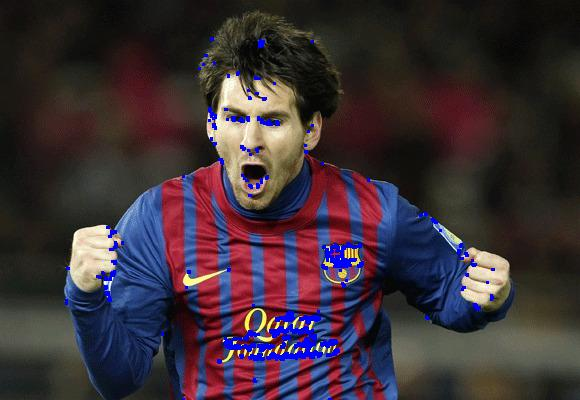

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [7]:
calculate_haris_corner("imgs/messi4.jpg")

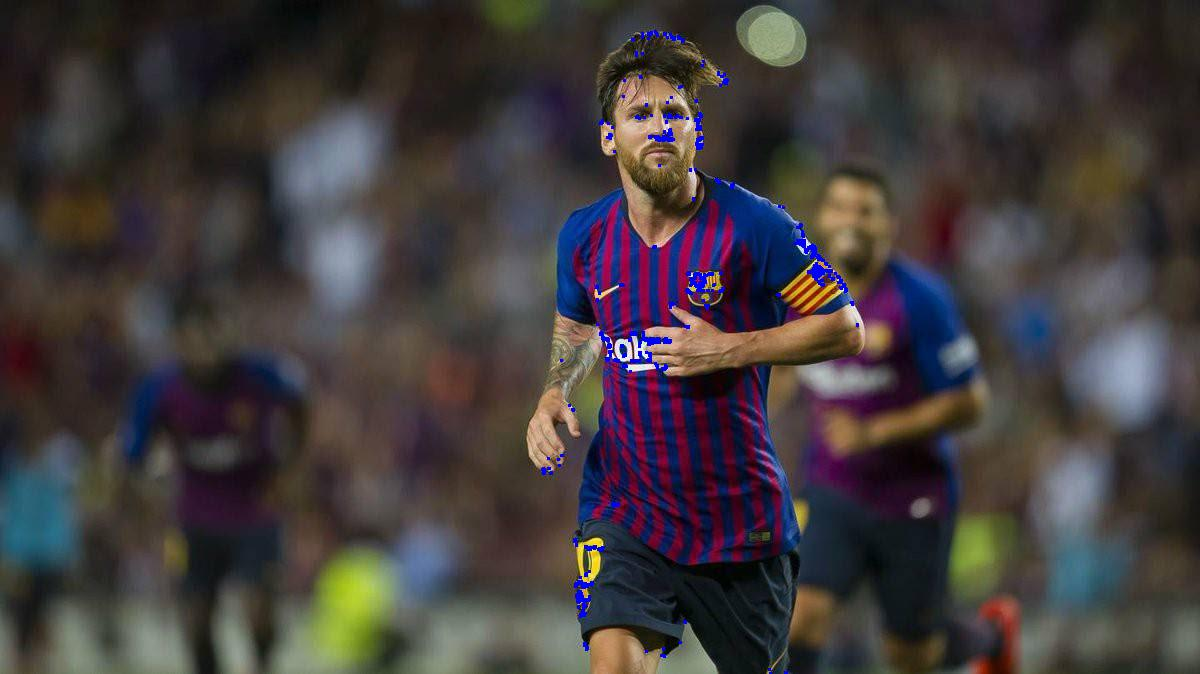

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [8]:
calculate_haris_corner("imgs/messi_alaves.jpg")

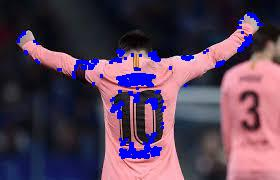

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [9]:
calculate_haris_corner("imgs/messi_espanyol.jpg")

# 👑<font color='red'>2 days ago, Lionel Messi scored two direct free-kicks in a single La Liga game for the first time as Barcelona beat Espanyol to move three points clear at the top.</font>👑





## Small Shifts

$$E(u,v)=\sum_{x,y}w(x,y)[I(x + u,y+v)-I(x,y)]^2$$

We want to find out how the error/energy function behaves for small shifts (u,v near 0,0)

We are going to do second-order Taylor expansion of E(u,v) about (0,0) (local quadratic approximation for small (u,v)

$$F(\delta x) \approx F(0) + \delta x \cdot \frac{dF(0)}{dx} + \frac{1}{2}\delta x^2\cdot\frac{d^2F(0)}{dx^2}$$


$$E(u,v) \approx E(0,0) + \begin{bmatrix}u&v\end{bmatrix} \begin{bmatrix}E_u(0,0)\\E_v(0,0)\end{bmatrix}  + \frac{1}{2}\begin{bmatrix}u&v\end{bmatrix}\begin{bmatrix}E_{uu}(0,0) & E_{uv}(0,0)\\E_{uv}(0,0)&E_{vv}(0,0)\end{bmatrix} \begin{bmatrix}u \\ v\end{bmatrix} $$

## Second- Order Taylor Expansion

Second-order Taylor expansion of E(u,v) about (0,0)
<br />

$$E_u(u,v) = \sum_{x,y}2w(x,y)[I(x+u,y+v)-I(x,y)]I_x(x+u,y+v)$$

u: is the offset in the x direction

$$E_{uu}(u,v) = \sum_{x,y}2w(x,y)I_x(x+u,y+v)I_x(x+u,y+v) + \sum_{x,y}2w(x,y)[I(x+u,y+v)-I(x,y)]I_{xx}(x+u,y+v)$$


<br/>

$$E_{uv}(u,v) = \sum_{x,y}2w(x,y)I_y(x+u,y+v)I_x(x+u,y+v) + \sum_{x,y}2w(x,y)[I(x+u,y+v)-I(x,y)]I_{xy}(x+u,y+v)$$


**Evalute E and its deivatives at (0,0)**


$$E(u,v) \approx E(0,0) + \begin{bmatrix}u&v\end{bmatrix} \begin{bmatrix}E_u(0,0)\\E_v(0,0)\end{bmatrix}  + \frac{1}{2}\begin{bmatrix}u&v\end{bmatrix}\begin{bmatrix}E_{uu}(0,0) & E_{uv}(0,0)\\E_{uv}(0,0)&E_{vv}(0,0)\end{bmatrix} \begin{bmatrix}u \\ v\end{bmatrix} $$

$$E_u(0,0) = \sum_{x,y}2w(x,y)[I(x,y)-I(x,y)]I_x(x,y)$$


$$E_{uu}(0,0) = \sum_{x,y}2w(x,y)I_x(x,y)I_x(x,y) + \sum_{x,y}2w(x,y)[I(x,y)-I(x,y)]I_{xx}(x,y)$$



$$E_{uv}(0,0) = \sum_{x,y}2w(x,y)I_y(x,y)I_x(x,y) + \sum_{x,y}2w(x,y)[I(x,y)-I(x,y)]I_{xy}(x,y)$$


$\implies$



$$E(u,v) \approx E(0,0) + \begin{bmatrix}u&v\end{bmatrix} \begin{bmatrix}E_u(0,0)\\E_v(0,0)\end{bmatrix}  + \frac{1}{2}\begin{bmatrix}u&v\end{bmatrix}\begin{bmatrix}E_{uu}(0,0) & E_{uv}(0,0)\\E_{uv}(0,0)&E_{vv}(0,0)\end{bmatrix} \begin{bmatrix}u \\ v\end{bmatrix} $$

$$E(0,0) = 0$$
$$E_u(0,0) = 0$$
$$E_v(0,0) = 0$$

$$E_{uu}(0,0) = \sum_{x,y}2w(x,y)I_x(x,y)I_x(x,y)$$
$$E_{vv}(0,0) = \sum_{x,y}2w(x,y)I_y(x,y)I_y(x,y)$$
$$E_{uv}(0,0) = \sum_{x,y}2w(x,y)I_x(x,y)I_y(x,y)$$


$\implies$



$$E(u,v) \approx \begin{bmatrix}u&v\end{bmatrix} \begin{bmatrix}\sum_{x,y}w(x,y)I^2_x(x,y) & \sum_{x,y}w(x,y)I_x(x,y)I_y(x,y) \\ \sum_{x,y}w(x,y)I_x(x,y)I_y(x,y) & \sum_{x,y}w(x,y)I^2_y(x,y)\end{bmatrix} \begin{bmatrix}u \\ v\end{bmatrix}$$


## Quadratic Approximation Simlification

The quadratic approximation simplifies to 
$$E(u,v) \approx \begin{bmatrix}u&v\end{bmatrix}M\begin{bmatrix}u \\ v\end{bmatrix}$$

Where <font color="green">M</font> is the <font color="green">second moment matrix</font> computed from image derivatives

$$M = \sum_{x,y} w(x,y) \begin{bmatrix}I^2_x & I_xI_y \\ I_xI_y&I^2_y\end{bmatrix}$$

furthermore, the second moment matrix can be written (without the weight):

$$M =  \begin{bmatrix} \sum I_xI_x & \sum I_xI_y \\ \sum I_xI_y & \sum I_yI_y\end{bmatrix} = \sum (\begin{bmatrix}I_x \\ I_y\end{bmatrix}\begin{bmatrix}I_x & I_y\end{bmatrix}) = \sum \nabla I(\nabla I)^T$$

## Interpreting the Second Moment Matrix

The surface E(u,v) is locally approximated by a quadratic form

$$E(u,v) \approx \begin{bmatrix}u&v\end{bmatrix}M\begin{bmatrix}u \\ v\end{bmatrix}$$

$$M = \sum_{x,y} w(x,y) \begin{bmatrix}I^2_x & I_xI_y \\ I_xI_y&I^2_y\end{bmatrix}$$

<br />
<figure>
  <img src="imgs/second_m_m.png" width="300" />
  <center><figcaption>Fig.4(a): Interpreting the Second Moment Matrix </figcaption></center>
</figure>

Consider a constant "slice" of E(u,v):

$$\sum I^2_xu^2 + 2\sum I_xI_yuv + \sum I^2_yv^2 = k$$

$$\begin{bmatrix}u&v\end{bmatrix}M\begin{bmatrix}u \\ v\end{bmatrix} = const$$

The first equation is an equation of an eliplse in the (u,v) space

<br />
<figure>
  <img src="imgs/second_m_m2.png" width="300" />
  <center><figcaption>Fig.4(b): Interpreting the second moment matrix constant case </figcaption></center>
</figure>


First, consider the axis-aligned case where gradients are either horizontal or vertical

$$M = \sum_{x,y} w(x,y) \begin{bmatrix}I^2_x & I_xI_y \\ I_xI_y&I^2_y\end{bmatrix} = \begin{bmatrix}\lambda_1& 0 \\ 0&\lambda_2\end{bmatrix}$$

If either $\lambda$ is close to 0, then this is not a corner, so look for locations where both are large


Diagonalization of M: $M = R^{-1}\begin{bmatrix}\lambda_1& 0 \\ 0&\lambda_2\end{bmatrix}R$

The axis lengths of the ellipse are determined by the eigenvalues and the orientation is determined by R
<br />
<figure>
  <img src="imgs/second_m_m3.png" width="500" />
  <center><figcaption>Fig.4(c): Direction of the fastest change
</figcaption></center>
</figure>



## Interpreting the eigenvalues

Classification of image points using eignvalues of M:

<br />
<figure>
  <img src="imgs/inter_eigenvalues.png" width="500" />
  <center><figcaption>Fig.5: Interpreting the eigenvalues
</figcaption></center>
</figure>



## Harris Corner Response Function

$$R = det(M) - \alpha trace(M)^2 = \lambda_1\lambda_2 - \alpha(\lambda_1 + \lambda_2)^2$$

$\alpha$: constant (0.04 to 0.06)

<br />
<figure>
  <img src="imgs/inter_eigenvalues2.png" width="250" />
  <center><figcaption>Fig.6: Interpreting the eigenvalues
</figcaption></center>
</figure>

R depends only on eigenvalues of M, but don't compute them (no sqrt, so really fast even in the '80s)<br/>
R is large for a <font color="green">corner</font><br/>
R is negative with large magnitued for an  <font color="green">edge</font><br/>
|R| is small a <font color="green">flat</font> region<br/>


## Textured Region

### Low texture region

<br />
<figure>
  <img src="imgs/low_tex_region.png" />
  <center><figcaption>Fig.7 (a): Low texture region</figcaption></center>
</figure>

### Edge

<br />
<figure>
  <img src="imgs/low_tex_region2.png" />
  <center><figcaption>Fig.7 (b): Edge</figcaption></center>
</figure>


### High textured region

<br />
<figure>
  <img src="imgs/low_tex_region3.png" />
  <center><figcaption>Fig.7 (c): High textured region</figcaption></center>
</figure>





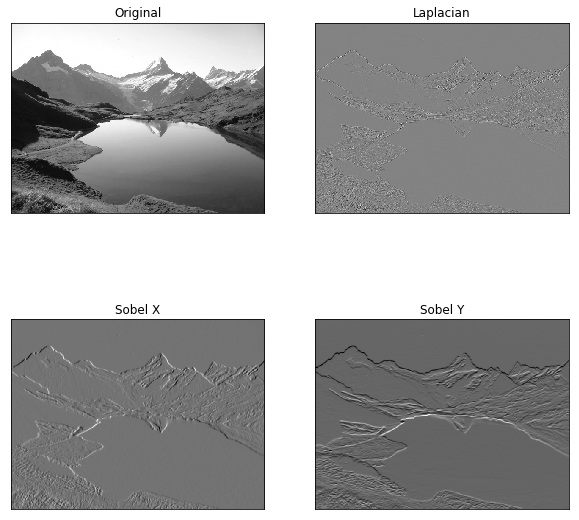

In [11]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = imread('imgs/nature.jpg')
gimg = green(img)

laplacian = cv.Laplacian(gimg,cv.CV_64F)
sobelx = cv.Sobel(gimg,cv.CV_64F,1,0,ksize=5)
sobely = cv.Sobel(gimg,cv.CV_64F,0,1,ksize=5)
plt.subplot(2,2,1),plt.imshow(gimg,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
fig = plt.gcf()
fig.set_size_inches((10,10))

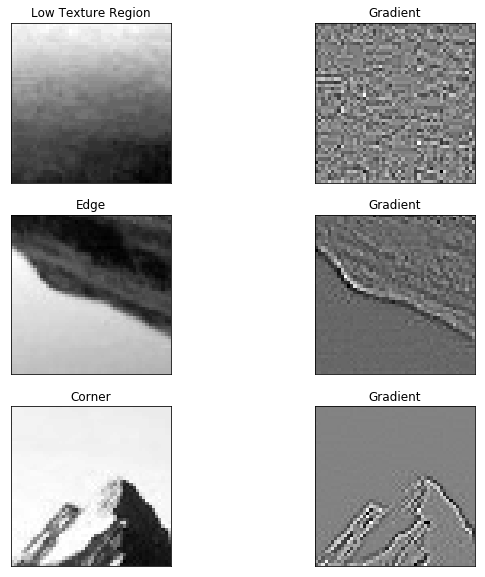

In [11]:
water = gimg[330:380,200:250]
wateredge = gimg[260:310,500:550]
summit = gimg[60:110,320:370]

gwater = cv.Laplacian(water,cv.CV_64F)
gwateredge = cv.Laplacian(wateredge,cv.CV_64F)
gsummit = cv.Laplacian(summit,cv.CV_64F)


plt.subplot(3,2,1),plt.imshow(water,cmap = 'gray')
plt.title('Low Texture Region'), plt.xticks([]), plt.yticks([])
plt.subplot(3,2,2),plt.imshow(gwater,cmap = 'gray')
plt.title('Gradient'), plt.xticks([]), plt.yticks([])
plt.subplot(3,2,3),plt.imshow(wateredge,cmap = 'gray')
plt.title('Edge'), plt.xticks([]), plt.yticks([])
plt.subplot(3,2,4),plt.imshow(gwateredge,cmap = 'gray')
plt.title('Gradient'), plt.xticks([]), plt.yticks([])

plt.subplot(3,2,5),plt.imshow(summit,cmap = 'gray')
plt.title('Corner'), plt.xticks([]), plt.yticks([])
plt.subplot(3,2,6),plt.imshow(gsummit,cmap = 'gray')
plt.title('Gradient'), plt.xticks([]), plt.yticks([])

fig = plt.gcf()
fig.set_size_inches((10,10))

## Harris detector: Algorithm

1. Compute Gaussian derivatives at each pixel
2. Compute second moment matrix M in a Gaussian window around each pixel
3. Compute corner response function R
4. Threshold R
5. Find local maxima of response function (nonmaximum suppression)

## Harris Detector Workflow


<br />
<figure>
  <img src="imgs/harris_workflow1.png" />
  <center><figcaption>Fig.8(a): Original Images</figcaption></center>
</figure>


<br />
<figure>
  <img src="imgs/harris_workflow2.png" />
  <center><figcaption>Fig.8(b): Compute corner response R</figcaption></center>
</figure>

<br />
<figure>
  <img src="imgs/harris_workflow3.png" />
  <center><figcaption>Fig.8(c): Find points with large corner response: R > threshold</figcaption></center>
</figure>

<br />
<figure>
  <img src="imgs/harris_workflow4.png" />
  <center><figcaption>Fig.8(d): Take only the points of local maxima of R</figcaption></center>
</figure>

<br />
<figure>
  <img src="imgs/harris_workflow5.png" />
  <center><figcaption>Fig.8(e): Final results</figcaption></center>
</figure>

In [12]:
def findCorners(filename, window_size, k, thresh):
    """
    Finds and returns list of corners and new image with corners drawn
    :param img: The original image
    :param window_size: The size (side length) of the sliding window
    :param k: Harris corner constant. Usually 0.04 - 0.06
    :param thresh: The threshold above which a corner is counted
    :return:
    """
    img = imread(filename)
    gimg = gray(img)
    #Find x and y derivatives
    dx = cv.Sobel(gimg,cv.CV_64F,1,0,ksize=5)
    dy = cv.Sobel(gimg,cv.CV_64F,0,1,ksize=5)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2
    height = int(img.shape[0])
    width = int(img.shape[1])

    cornerList = []
    color_img = img.copy()
    offset = int(window_size/2)

    #Loop through image and find our corners
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            #Calculate sum of squares
            windowIxx = Ixx[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIxy = Ixy[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIyy = Iyy[y-offset:y+offset+1, x-offset:x+offset+1]
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()

            #Find determinant and trace, use to get corner response
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            r = det - k*(trace**2)
            
            ## For some reason the values are very high, so devide
            r = r/1000000000000.0
            
            #If corner response is over threshold, color the point and add to corner list
            if r  > thresh:
                cornerList.append([x, y, r])
                color_img.itemset((y, x, 0), 0)
                color_img.itemset((y, x, 1), 0)
                color_img.itemset((y, x, 2), 255)
    imshow(color_img)

OpenCV implementation


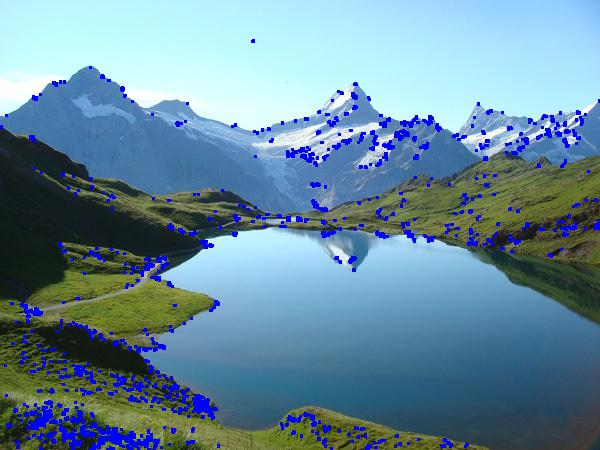

Local implementation


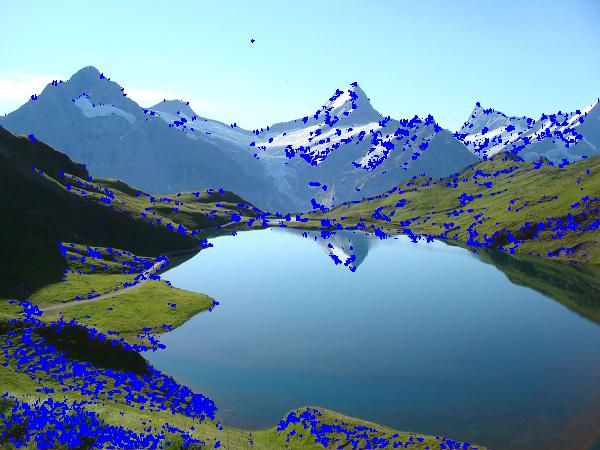

In [13]:
print("OpenCV implementation")
calculate_haris_corner('imgs/nature.jpg')
print("Local implementation")
findCorners("imgs/nature.jpg",2.0,0.04,10.0)

## Other corners:

Shi-Tomasi '94:

"Cornerness" = $min(\lambda_1,\lambda_2)$ Find local maximums cvGoodFeaturesToTrack(..)<br/>
Reportedly better for refion undergoing affine deformations
<br />
<figure>
  <img src="imgs/other_corners.png" />
  <center><figcaption>Fig.9</figcaption></center>
</figure>
<br />
- Brown, M., Szeliski, R., and Winder, S. (2005):
$$\frac{det\,\, M}{tr\,\, M} = \frac{\lambda_0\lambda_1}{\lambda_0+\lambda_1}$$

- There are others....

In [14]:
## cvGoodFeaturesToTrack

# =====================================
#  4A - L3 Scale invariance
# =====================================

## Harris Detector Properties

Rotation invariance?

<br />
<figure>
  <img src="imgs/rotation_harris.png" />
  <center><figcaption>Fig.9(a): Rotation invariance</figcaption></center>
</figure>


Ellipse rotates but its shape (i.e. eigenvalues) remains the same

Repeatability rate:

$$\frac{\# correspondences}{\# possible\,\, correspondences}$$

<figure>
  <img src="imgs/rotation_harris2.png" />
  <center><figcaption>Fig.9(b): Repeatability rate</figcaption></center>
</figure>



In [15]:
## You are welcome to show the previous theory in code....

## More Haris Detector Properties

- Mostly invariant to additive and multiplicative intensity changes(threshold issue for multiplicative)
    - Only derivatives are used -> invariance to intensity shift I --> I +  b
    - Intensity scale: I --> a*I
    
<br />
<figure>
  <img src="imgs/multi_harris.png" />
  <center><figcaption>Fig.10 (a): Multiplicative intensity</figcaption></center>
</figure>


- Invariant to image scale?
    - <font color="red">Not</font> invariant to image scale!
    
<br />
<figure>
  <img src="imgs/scale_harris.png" />
  <center><figcaption>Fig.10 (b): Harris not invariant to scale</figcaption></center>
</figure>
<br />
<figure>
  <img src="imgs/scale_harris2.png" />
  <center><figcaption>Fig.10 (c): Repeatability measure for scale</figcaption></center>
</figure>

In [16]:
## You are welcome to show the previous theory in code....

## Scale Invariant Detection

- Consider regions (e.g. circles) of different sizes around a point
- Regions of corresponding sizes will look the same in both images

- The problem: how do we choose corresponding circles <font color="green">independently</font> in each image?

<br />
<figure>
  <img src="imgs/scale_inv_harris.png" />
  <center><figcaption>Fig.11: scale invariant</figcaption></center>
</figure>


- Solution:
    - Design a function on the region (circle), which is "scale invariant" - not affected by the size but will be the same for "corresponding regions," even if they are at different sizes/scales

    <font color="blue">Example</font>: Average intensity. For corresponding regions (even of different sizes) it will be the same

## One Method fro Scale Invariant Detection

One method:
- At a point, compute the scale invariant function of different size neighborhoods (different scales).


<br />
<figure>
  <img src="imgs/one_method_s_i.png" />
  <center><figcaption>Fig.12 (a) scalling around a certain point</figcaption></center>
</figure>

- Important: this scale invariant region size is found in each image independently



<br />
<figure>
  <img src="imgs/one_method_s_i2.png" />
  <center><figcaption>Fig.12 (b) example</figcaption></center>
</figure>



In [17]:
## You are welcome to show the previous theory in code....

## A Food Function for Scale Detection

- A "good" function for scale detection:
    has one stable sharp peak
    
<br />
<figure>
  <img src="imgs/good_s_i_func.png" />
  <center><figcaption>Fig.13 (a): good scale invariant function</figcaption></center>
</figure>

For usual images: a good function would be a one which responds to contrast (sharp local intensity change)

Function is just application of a kernel: <font color="green"> f = Kernel * Image</font>

$$ L = \sigma^2(G_{xx}(x,y,\sigma) + G_{yy}(x,y,\sigma))$$

Laplacian of Gaussian- LoG

$$ DoG = \sigma^2(G_{xx}(x,y,k\sigma) + G_{yy}(x,y,\sigma))$$

Difference of Gaussians

Both kernals are invariant to scale and rotation

<br />
<figure>
  <img src="imgs/good_s_i_func2.png" width=300/>
  <center><figcaption>Fig.13 (b): LoG vs DoG</figcaption></center>
</figure>

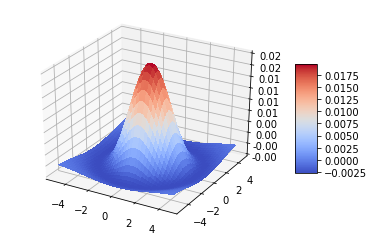

In [18]:
## Show Laplacian of Gaussian

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
#R = np.sqrt(X**2 + Y**2)
#R = X**2 + Y**2
sigma = 2
Z = -1*1/(np.pi*np.power(sigma,4))*(1-(X**2 + Y**2)/(2*np.power(sigma,2)))*np.exp(-(X**2 + Y**2)/(2*np.power(sigma,2)))
Z *= -1

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

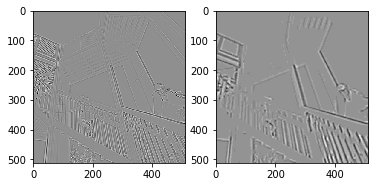

In [19]:
from scipy import ndimage, misc
import matplotlib.pyplot as plt
ascent = misc.ascent()
fig = plt.figure()
plt.gray()  # show the filtered result in grayscale
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
result = ndimage.gaussian_laplace(ascent, sigma=1)
ax1.imshow(result)
result = ndimage.gaussian_laplace(ascent, sigma=3)
ax2.imshow(result)
plt.show()

## Key Point Localization

- General idea: find robust extremum (maximum of minimum) both in space in scale
- Specific suggestion: use DoG pyramid to find maximum values (remember edge detection?) - then eliminate "edges" and pick only corners

### Scale space processed one octave at a time

<br />
<figure>
  <img src="imgs/key_point_localization.png" width=300 />
  <center><figcaption>Fig.14 (a): key point localization</figcaption></center>
</figure>


Each point is compared to its 8 neighbors in the current image and 0 neighbors each in the scale above and below

<br />
<figure>
  <img src="imgs/key_point_localization2.png" width=300 />
  <center><figcaption>Fig.14 (b): key point localization</figcaption></center>
</figure>

## Extrema at different scales

<br />
<figure>
  <img src="imgs/extrema_dif_sc.png" width=300 />
  <center><figcaption>Fig.15(a): Extrema at different scales</figcaption></center>
</figure>
<br />
<figure>
  <img src="imgs/extrema_dif_sc2.png"  width=300/>
  <center><figcaption>Fig.15(b): Extrema at different scales</figcaption></center>
</figure>

### Scale Invariant Detectors

SIFT(LOWE)<br />
Find local maximum of:
- Difference of Gaussians in space and scale

<br />
<figure>
  <img src="imgs/sift.png"  width=300/>
  <center><figcaption>Fig.15(c): Sift</figcaption></center>
</figure>

Harris-Laplacian<br />
Find local maximum of:
    - Harris corner detector in space (image coordinates)
    - Laplacian in scale
    
<br />
<figure>
  <img src="imgs/harris_laplacian.png"  width=300/>
  <center><figcaption>Fig.15(d): harris-laplacian</figcaption></center>
</figure>


<br />
<figure>
  <img src="imgs/harris_vs_sift.png"  width=300/>
  <center><figcaption>Fig.15(e): harris vs sift</figcaption></center>
</figure>

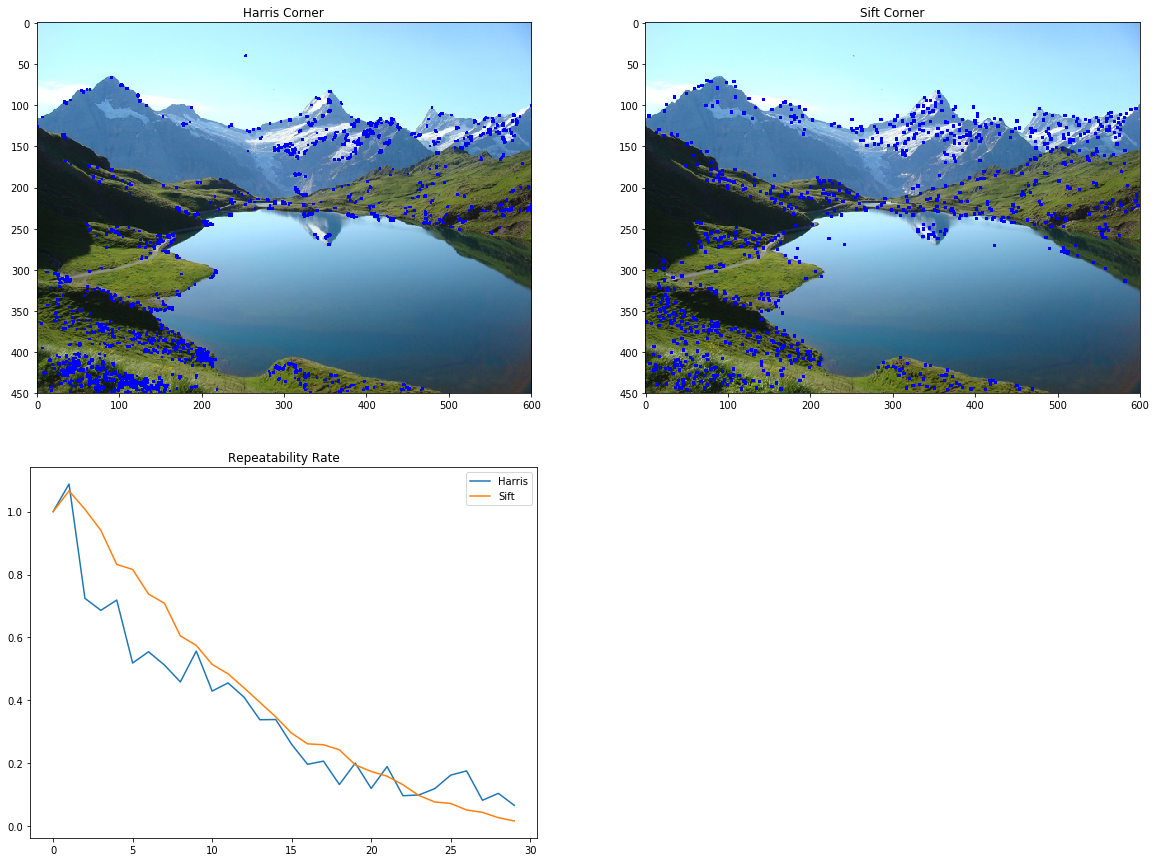

In [107]:
## Code to show comparision
import itertools
import cv2
def resize(image,size):
    return cv2.resize(image, size) 
def get_box(nx,ny,center_x,center_y,size): 
    x = center_x
    y = center_y
    x_i = np.arange(max(0,x-size),min(nx,x+size))
    y_i = np.arange(max(0,y-size),min(ny,y+size))
    return list(itertools.product(x_i,y_i))
        
def set_corner(img,x,y,size=3,color=[0,0,255]):
    box = get_box(img.shape[1],img.shape[0],x,y,size)
    for x,y in box:
        img.itemset((y, x, 0), color[0])
        img.itemset((y, x, 1), color[1])
        img.itemset((y, x, 2), color[2])
def calculate_sift_corner(img,show=True,plotid=111):
    if type(img) == str:
        img = imread(img)
    gimg = gray(img)
    sift = cv2.xfeatures2d.SIFT_create()
    kp = sift.detect(gimg,None)
    for p in kp:
        #print(x.pt)
        x,y = min(int(p.pt[0]),img.shape[1]-1),min(int(p.pt[1]),img.shape[0]-1)
        set_corner(img,x,y,2)
    if show:
        ax = plt.subplot(plotid)
        ax.set_title("Sift Corner")
        ax.imshow(img)
    return kp
def calculate_haris_corner(img,show=True,plotid=111):
    if type(img) == str:
        img = imread(img)
    gimg = gray(img)
    gimg = np.float32(gimg)
    dst = cv2.cornerHarris(gimg,2,3,0.04)

    #result is dilated for marking the corners, not important
    dst = cv2.dilate(dst,None)

    # Threshold for an optimal value, it may vary depending on the image.
    img[dst>0.01*dst.max()]=[0,0,255]
    if show:
        ax = plt.subplot(plotid)
        ax.set_title("Harris Corner")
        ax.imshow(img)
    return np.argwhere(dst>0.01*dst.max())

nature = imread('imgs/nature.jpg')
nx,ny,_ = nature.shape
# corners_center = [(90,65,3),(185,100,3),(354,82,3),(430,113,3),
#                   (478,102,3),(354,269,3),(211,245,3),
#                   (215,302,3),(233,235,3),(160,346,3)]
n = 30
scales = np.linspace(1,0.1,n)
## Harris corners with scale
harris_p = calculate_haris_corner(nature.copy(),plotid=221)
possible = len(harris_p)
harris_per = [len(calculate_haris_corner(resize(nature.copy(),(int(ny*s),int(nx*s))),False))/possible for s in scales]
## Sift corners with scale
sift_p = calculate_sift_corner(nature.copy(),plotid=222)
possible = len(sift_p)
sift_per = [len(calculate_sift_corner(resize(nature.copy(),(int(ny*s),int(nx*s))),False))/possible for s in scales]

ax = plt.subplot(223)
ax.plot(np.arange(n),harris_per,label="Harris")
ax.plot(np.arange(n),sift_per,label="Sift")
ax.legend()
ax.set_title("Repeatability Rate")
fig = plt.gcf()
fig.set_size_inches((20,15))

# =====================================
#  4B - L1 SIFT Descriptor
# =====================================

### Point Descriptors

How to match points detected using, for example, Harris detector?

<br />
<figure>
  <img src="imgs/detecting_points.png" />
  <center><figcaption>Fig.16: Similar Points</figcaption></center>
</figure>

- We need to describe them -a <font color="blue">descriptor</font>

### Criteria for Point Descriptors

- We want the descriptors to be the (almost: without duplication) same in both image - *invariant*

- We also need the descriptors to be <font color="blue">distinctive</font> (different points have different descriptors)

### Simple solution? <font color="red">Not so good</font>

- Harris gives good detection - and we also know the scale
- Why not just use correlation to check the match of the window around the feature in image 1 with every feature in image 2

- Not so good because: 
    - Correlation is not rotation invarian - why do we want this?
    - Correlation is sensitive to photometric changes
    - Normalized correlation is sensitive to non-linear photometric changes and even slight geometric ones
    - Could be slow - check all features against all features

## SIFT (Scale Invariant Feature Transform)

- Motivation: The harris operator was not invariant to scale and correlation was not invariant to rotation

- For better image matching, Lowe's goals were:
    - To develop an interest operator - a dtector - that is invariant to scale and rotation
    - Also: create a <font color="blue">descriptor</font> that was robust to the variations corresponding to typical viewing conditions. <font color="blue">*The descriptor is the most-used part of SIFT*</font>

## Idea of SIFT

- Image content is represented by a constellation of local features that are invariant to translation, rotation, scale, and other imaging parameters

### SIFT Features

<br />
<figure>
  <img src="imgs/sift_features.png" />
  <center><figcaption>Fig.17: example of SIFT features</figcaption></center>
</figure>

## Overall SIFT Procedure

- Scale-space extrema detection <font color="green">(...Or use Harris-Laplace or other method)</font>
- Keypoint localization <font color="green">(...Or use Harris-Laplace or other method)</font>
<br />

- Orientation assignment
- Keypoint description




## Orientation Assignment

1. Scale-space extrema detection 
2. Keypoint localization
3. <font color="blue">Orientation assignment</font>
Compute best orientations(s) for each keypoint region.
4. Keypoint description
Use local image gradients at selected scale and rotation to describe each keypoint region

### Descriptors Invariant to Rotation

- Find the dominant direction of gradient - that is the base orientation
- Compute image derivatives relative to this orientation

<br />
<figure>
  <img src="imgs/des_inv_rotation.png" />
  <center><figcaption>Fig.18 (a): Derivatives orientation </figcaption></center>
</figure>
<br />
<br />

<div class="container" style="width: 100%;">
    <div class="sidebar" style="width: 400px; float: left;">
<br />
<br />
<br />
<br />
        
- Create histogram of local gradient directions at <font color="blue">selected</font> scale - 36 bins <br/>
- Assign canonical orientation at peak of smoothed histogram<br/>
- Each <font color="blue">keypoint</font> now specifies stable 2D coordinates (x,y, scale, orientation) - invariant to those
    </div>
    <div class="content" style="margin-left: 402px;">
        
<figure>
  <img src="imgs/histogram_local.png" width="200px" />
    <figcaption>Fig.18 (b): Histogram of local gradient </figcaption>
</figure>
    </div>
</div>


<font color="blue">**Quiz**</font>

What is the dominant oritentation for the image below?

<br />
<figure>
  <img src="imgs/quiz1.png" />
  <center><figcaption>Fig.19 Quiz </figcaption></center>
</figure>

## 4. Keypoint Descriptors

- Next is compute a descriptor for the local image region about each keypoint that is:
    - Highly <font color="blue">distinctive</font>
    - As <font color="blue">invariant</font> as possible to variations such as changes in viewpoint and illumination

### But first... normalization...

- Rotate the window to standard orientation
- Scale the window size based on the scale at which the point was found

## Compute a feature vector based upon: 

    - Histogram of gradients
    - weighted by the magnitude of the gradient
  
<br />    
<figure>
      <img src="imgs/g_histogram.png" />
      <center><figcaption>Fig.20 Histogram of gradients </figcaption></center>
</figure>

## Smoothness

The smoothness allows you to get slow change in the descriptor as you move just a little bit

<br />
<figure>
  <img src="imgs/smoothness.png" />
  <center><figcaption>Fig.21 smoothing </figcaption></center>
</figure>

### Reduce effect of illumination

- Clip gradient magnitudes to avoid excessive influence of high gradients
    - after rotation normalization, clamp gradients > 0.2
- 128-dim vector normalized to magnitude 1.0


## Evaluating the SIFT descriptors

- Database images were subjected to rotation, scaling, affine, stretch, brightness, and contrast changes, and added noise
- Feature point detectors and descriptors were compared before and after the distortions
- Mostly looking for stability with respect to change

<br />
<figure>
  <img src="imgs/evaluate_sift.png" />
  <center><figcaption>Fig.22(a) Evaluating SIFT</figcaption></center>
</figure>

<br />
<figure>
  <img src="imgs/evaluate_sift2.png" />
  <center><figcaption>Fig.22(b) Evaluating SIFT</figcaption></center>
</figure>

## Experimental Results

<br />
<figure>
  <img src="imgs/experimental_results_sift.png" />
  <center><figcaption>Fig.23(a): Experimental Results </figcaption></center>
</figure>

<br />
<figure>
  <img src="imgs/experimental_results_sift2.png" />
  <center><figcaption>Fig.23(b): Experimental Results 2</figcaption></center>
</figure>

<br />
<figure>
  <img src="imgs/experimental_results_sift3.png" />
  <center><figcaption>Fig.23(c): Experimental Results 3</figcaption></center>
</figure>

## Experiment in code

### Generating SIFT Features

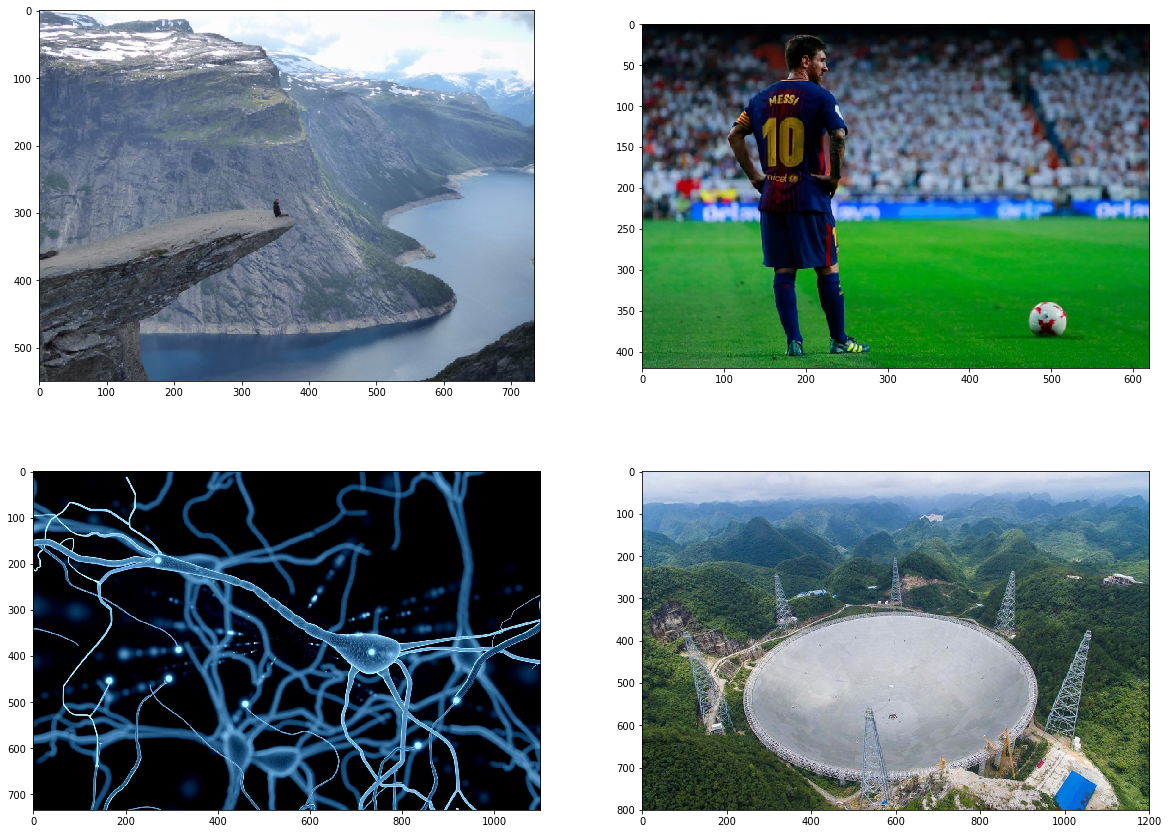

In [156]:
## We will test SIFT on the following images that were drawn randomly from the internet
imgs = [imread("imgs/ev_sift%d.jpg" % i) for i in range(1,5)]
fig = plt.gcf()
fig.set_size_inches((20,15))
plt.subplot(221).imshow(imgs[0])
plt.subplot(222).imshow(imgs[1])
plt.subplot(223).imshow(imgs[2])
plt.subplot(224).imshow(imgs[3])

In [28]:
def gen_sift_features(gray_img):
    sift = cv.xfeatures2d.SIFT_create()
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def show_sift_features(gray_img, color_img, kp,ax):
    fig = plt.gcf()
    fig.set_size_inches((20,8))
    return ax.imshow(cv.drawKeypoints(gray_img, kp, color_img.copy()))

In [158]:
sifts = [gen_sift_features(gray(img)) for i in imgs]

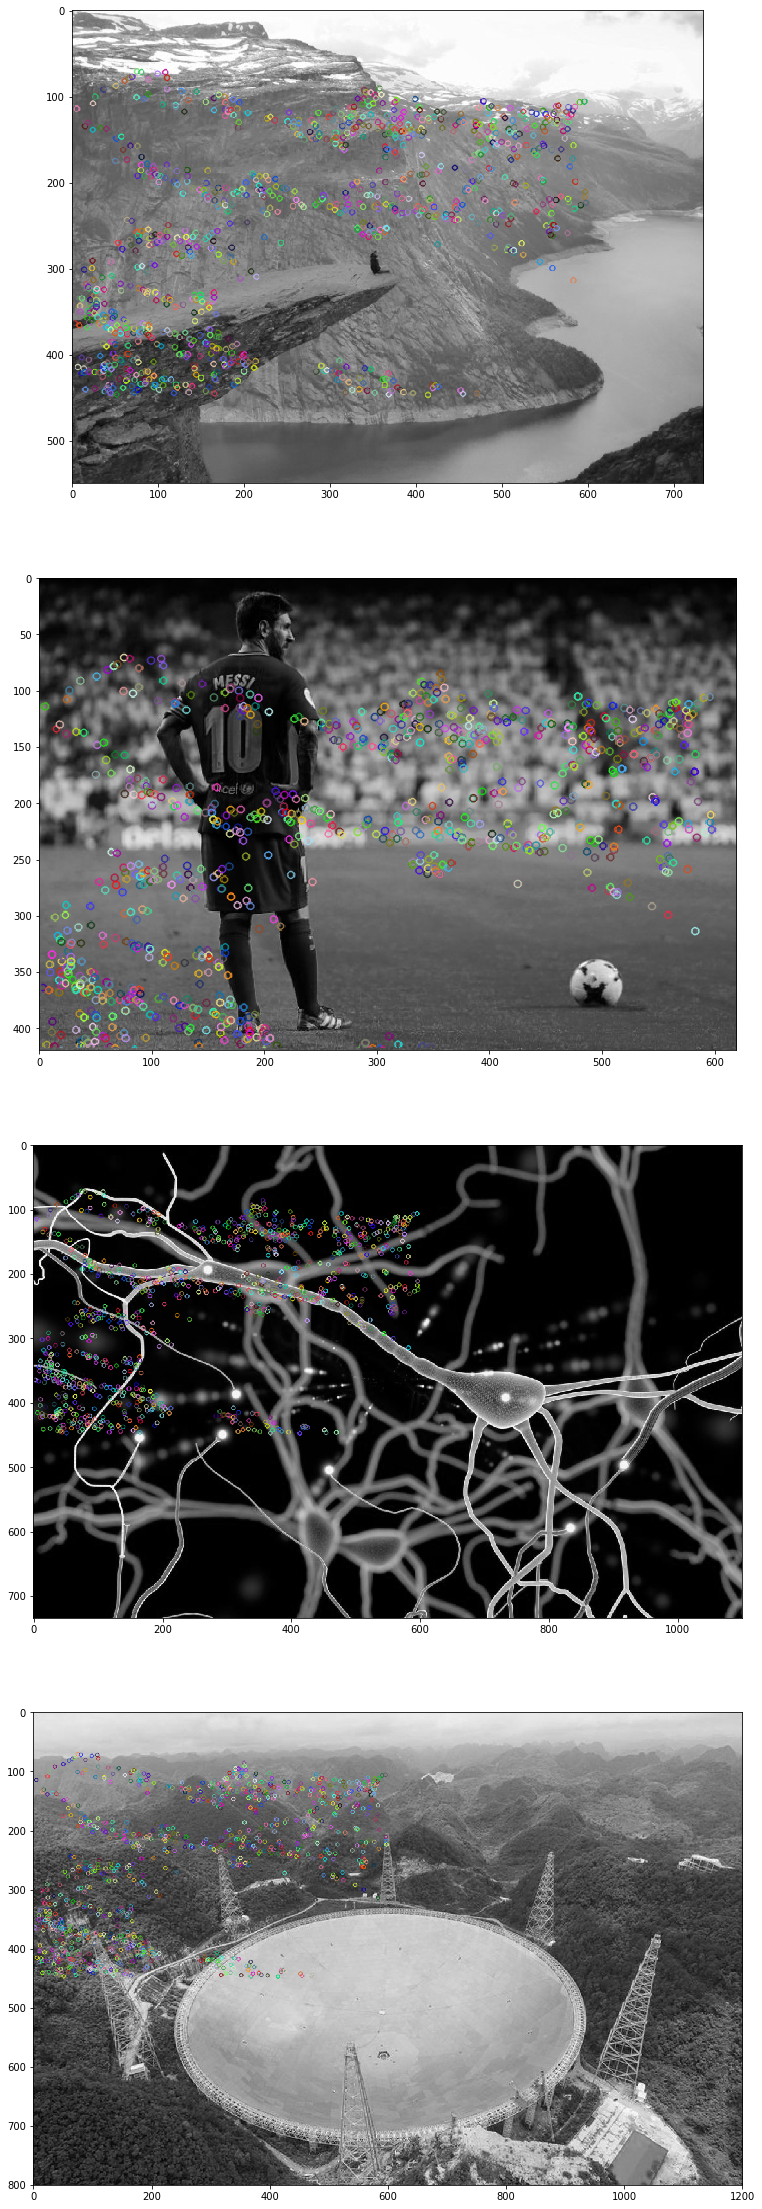

In [159]:
fig = plt.gcf()
fig.set_size_inches((20,40))
show_sift_features(gray(imgs[0]), imgs[0], sifts[0][0],ax=plt.subplot(411))
show_sift_features(gray(imgs[1]), imgs[1], sifts[1][0],ax=plt.subplot(412))
show_sift_features(gray(imgs[2]), imgs[2], sifts[2][0],ax=plt.subplot(413))
show_sift_features(gray(imgs[3]), imgs[3], sifts[3][0],ax=plt.subplot(414))

<font color="red" size="6pt">**Not Quite Impressive**</font>
## Feature Matching Using SIFT

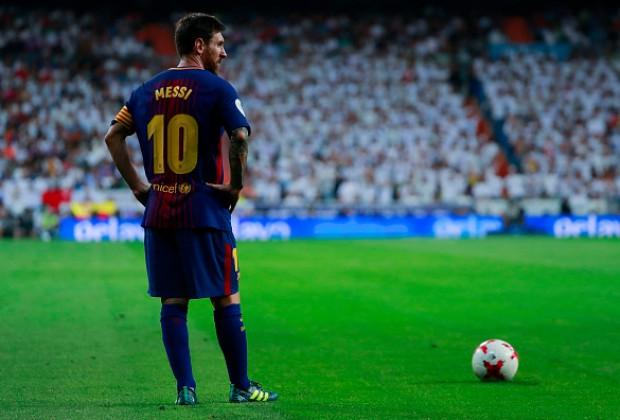

In [130]:
messi = imgs[1]
imshow(messi)

In [140]:
messi_name = messi[80:105,140:200]
imshow(messi_name)

In [147]:
kp1,desc1 = gen_sift_features(gray(messi_name))

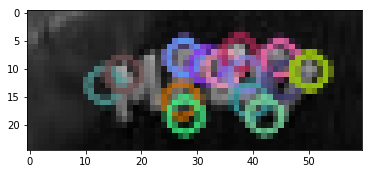

In [148]:
show_sift_features(gray(messi_name), messi_name, kp,ax=plt.subplot())

# =====================================
#  4B - L2 Matching Feature Points (a little)
# =====================================

## Nearest Neighbor

- Better: hypotheses are generated by <font color="blue">approximate nearest neighbor</font> matching of each feature to vectors in the database
    - SIFT uses best-bin-first (Beis & Lowe, 97) modification to k-d tree algorithm
    - Use heap data structure to identify bins in order by their distance from query point

### Nearest-neighbor matching to feature database

- Result: can give speedup by factor of <font color="blue">100-1000</font> while finding nearest neighbor (of interest) 95% of the time

### Nearest-neighbor technique
<br />
<figure>
  <img src="imgs/nn_technique.png" />
  <center><figcaption>Fig.24: Nearest neighbor techniques </figcaption></center>
</figure>

## Wavelet-Based Hashing

Compute a short (3-vector) descriptor from the neightborhood using a Haar "wavelet"

Quantize each value into 10 (overlapping) bins ($10^3$ total entries)

<br />
<figure>
  <img src="imgs/wavelet_hashing.png" />
  <center><figcaption>Fig.25: wavelet hashing </figcaption></center>
</figure>

## Locality Sensitive Hashing

- Idea: construct hash function g: <font color="green">$R^d \rightarrow U$</font> such that for any points <font color="green">p,q</font>:
    - If <font color="green">$D(p,q) \leq r$</font>, then <font color="green">Pr[g(p)=g(q)]</font> is <strike>"high"</strike> "not-so-small"
    - If <font color="green">$D(p,q) > cr$</font>, then <font color="green">Pr[g(p)=g(q)]</font> is "small"

- Then we can solve the problem by hashing

<br />
<figure>
  <img src="imgs/locality_sen_hashing.png" />
  <center><figcaption>Fig.26: locality sensitive hashing</figcaption></center>
</figure>

## 3D Object Recognition


<div class="container" style="width: 100%;">
    <div class="sidebar" style="width: 400px; float: left;">
        
Train: <br/>
1. Extract outlines with background subtraction <br/>
2. Compute "keypoints" - interest points and descriptors <br/>

Test: <br/>
1. Find possible matches.
2. Search for consistent solution - such as affine. (How many points?!?!?!)
    </div>
    <div class="content" style="margin-left: 400px;">
<figure>
  <img src="imgs/threedobjectrecognition.png" />
  <center><figcaption>Fig.27</figcaption></center>
</figure>
    </div>
</div>


## Recognition  Under Occlusion

<br />
<figure>
  <img src="imgs/reco_under_occ.png" />
  <img src="imgs/reco_under_occ2.png" />
  <center><figcaption>Fig.28 Recognition examples </figcaption></center>
</figure>

## Code Time

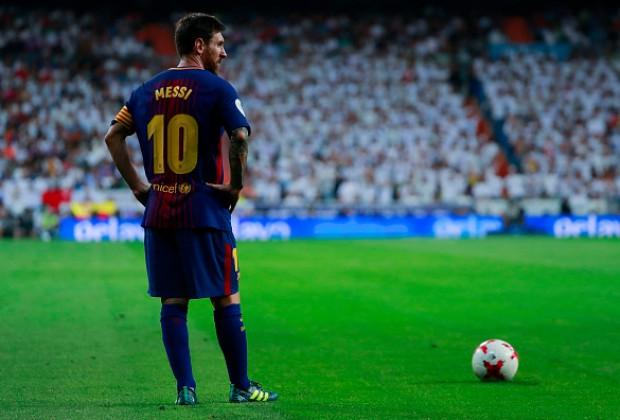

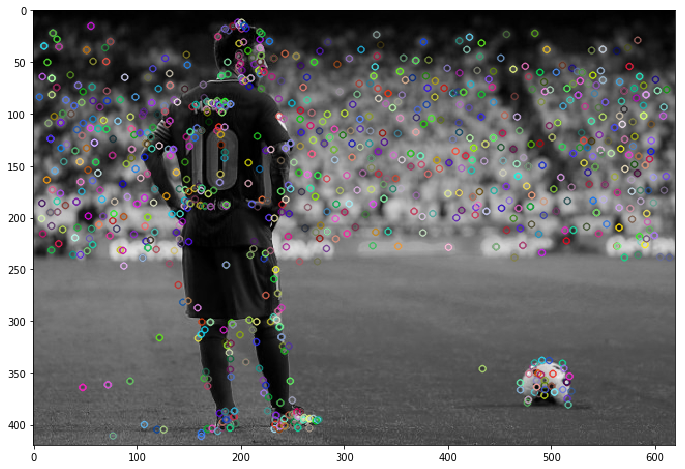

In [29]:
messi = imread("imgs/ev_sift2.jpg")
messi_kp, messi_desc = gen_sift_features(gray(messi))
imshow(messi)
show_sift_features(gray(messi), messi, messi_kp,ax=plt.subplot())

In [30]:
messi_name = messi[80:105,140:200]
imshow(messi_name)

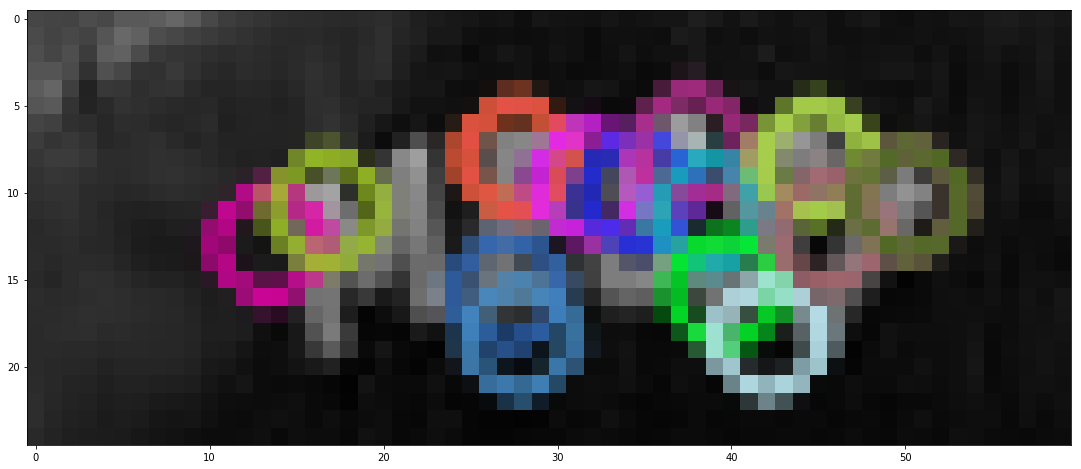

In [31]:
messiname_kp,messiname_desc = gen_sift_features(gray(messi_name))
show_sift_features(gray(messi_name), messi_name, messname_kp,ax=plt.subplot())

### Using KNN

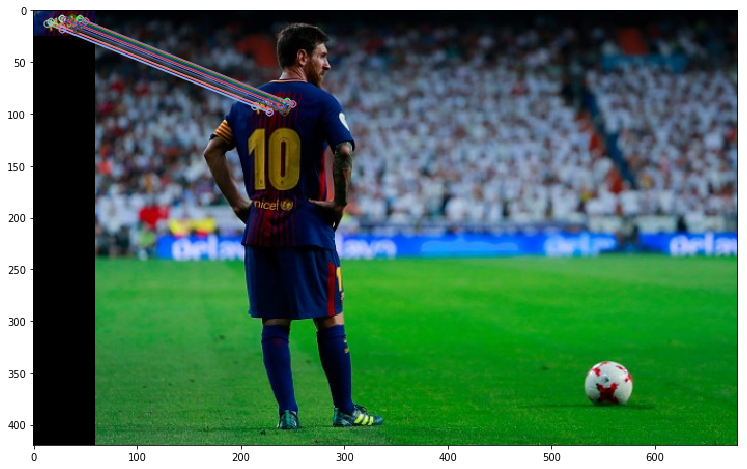

(<matplotlib.image.AxesImage at 0x11d72ee10>, None)

In [32]:
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(messiname_desc,messi_desc, k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(messi_name,messiname_kp,messi,messi_kp,good,None,flags=2)
fig = plt.gcf()
fig.set_size_inches((20,8))
plt.imshow(img3),plt.show()

### Using FLANN

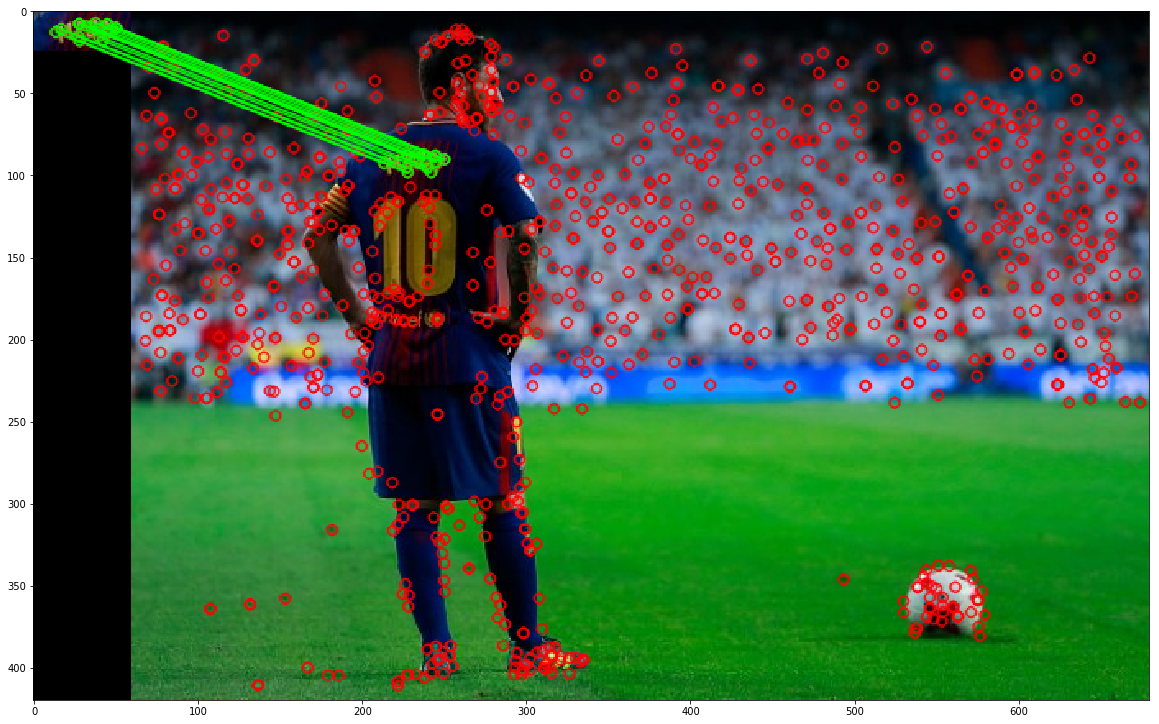

(<matplotlib.image.AxesImage at 0x11fcc5c88>, None)

In [33]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(messiname_desc,messi_desc,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(messi_name,messiname_kp,messi,messi_kp,matches,None,**draw_params)
fig = plt.gcf()
fig.set_size_inches((20,40))
plt.imshow(img3,),plt.show()

### Lets rotate the image, and scale it and see if it is able to find Messi's name

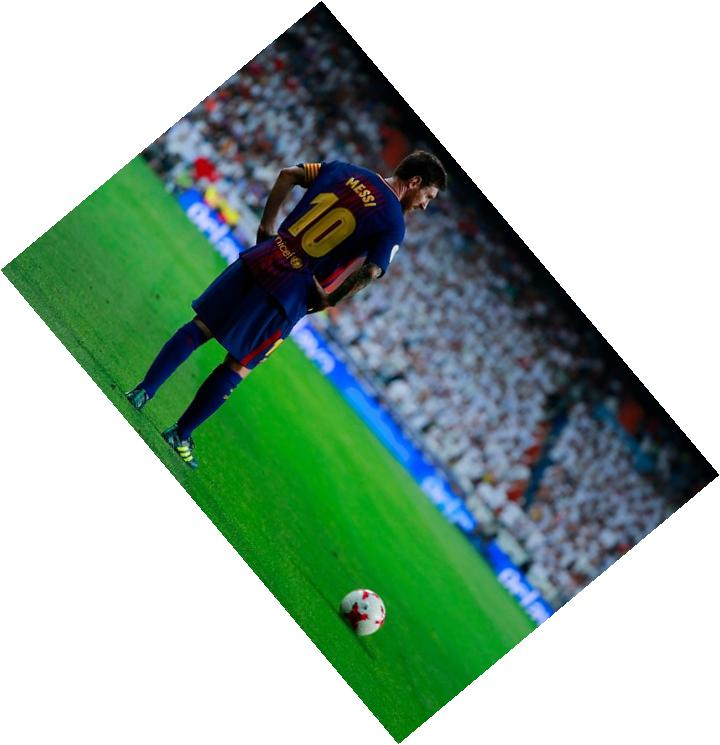

In [140]:
import scipy.ndimage
rmessi = scipy.ndimage.rotate(messi,-50,cval=255)
imshow(rmessi)

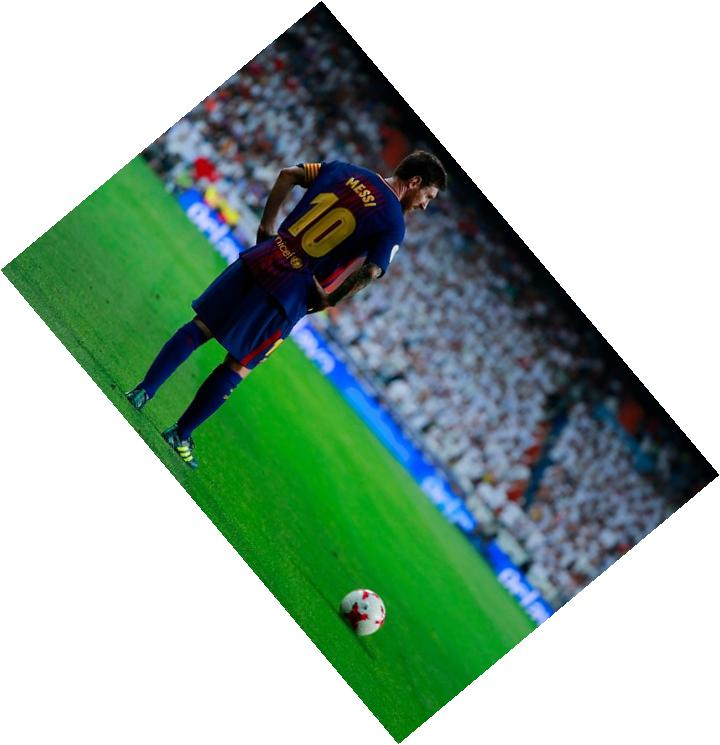

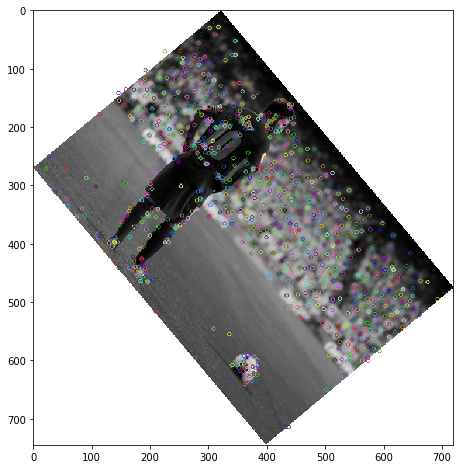

In [141]:
rmessi_kp, rmessi_desc = gen_sift_features(gray(rmessi))
imshow(rmessi)
show_sift_features(gray(rmessi), rmessi, rmessi_kp,ax=plt.subplot())

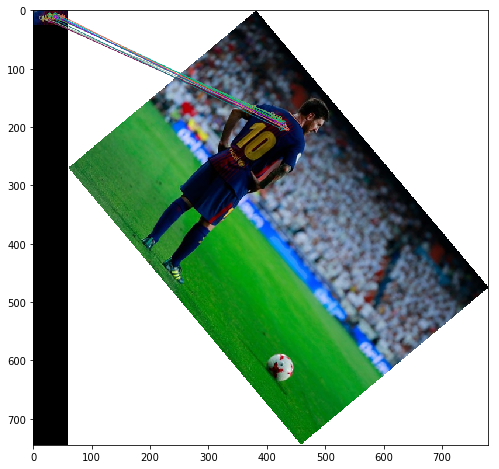

(<matplotlib.image.AxesImage at 0x12a5ca2b0>, None)

In [142]:
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(messiname_desc,rmessi_desc, k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(messi_name,messiname_kp,rmessi,rmessi_kp,good,None,flags=2)
fig = plt.gcf()
fig.set_size_inches((20,8))
plt.imshow(img3),plt.show()

### Great. Lets scale it

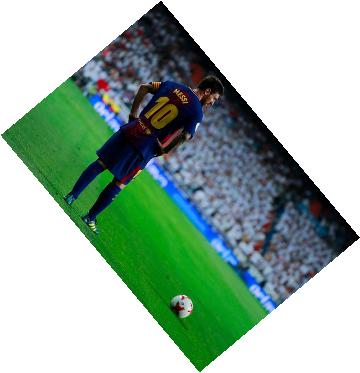

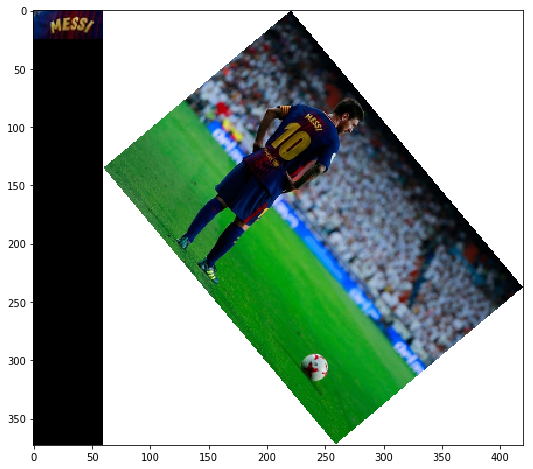

(<matplotlib.image.AxesImage at 0x128671e48>, None)

In [143]:
smessi = rmessi[::2,::2] ## scaling by 1/2
smessi_kp, smessi_desc = gen_sift_features(gray(smessi))

imshow(smessi)
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(messiname_desc,smessi_desc, k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(messi_name,messiname_kp,smessi,smessi_kp,good,None,flags=2)
fig = plt.gcf()
fig.set_size_inches((20,8))
plt.imshow(img3),plt.show()

## Was not found. Lets see why

<Figure size 432x288 with 0 Axes>

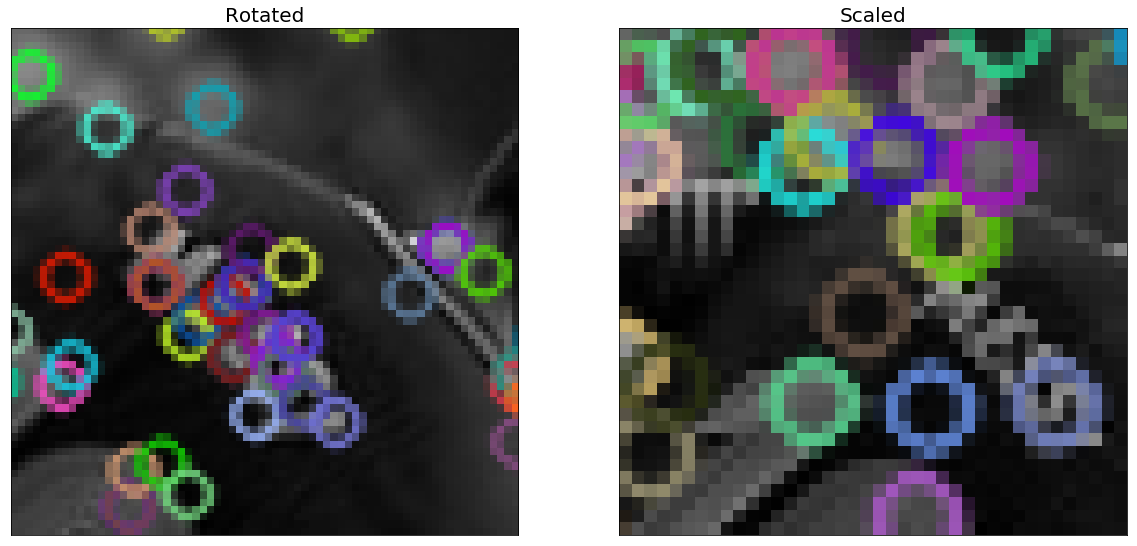

In [144]:
## Stolen from L2.ipynb
def display_pair(imgs,titles):
    plt.gray()
    plt.figure(figsize=(20,20))
    
    plt.subplot(121)
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())   
    plt.imshow(imgs[0])
    plt.title(titles[0], size=20)
    if len(imgs)> 1:
        plt.subplot(122)
        plt.imshow(imgs[1])
        plt.title(titles[1], size=20)
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())   
    plt.show()


rotated = cv.drawKeypoints(gray(rmessi), rmessi_kp, rmessi.copy())
scaled = cv.drawKeypoints(gray(smessi), smessi_kp, smessi.copy())
rotated_name = rotated [150:220,330:400]
scaled_name = scaled[70:110,150:190]
display_pair([rotated_name,scaled_name],["Rotated","Scaled"])

### As it appears from above, the reason is that, unlike the rotate version, when we scaled down the image, only two feature points were detected around Messi's name and thus the template couldn't be matched. 

# <font color='red'>  🤩🎩👏🏻 Last day of 2018. Messi finished the year of 2018 as the top scorer. He scored 51 goals. Moreover, while he had tough year in terms of teams' trophies, he was, as always at his top level, and continued to entertain, equally, his lovers and his haters. 🤩🎩👏🏻</font>

## SIFT in Sony Aibo

SIFT usage:

- Recognize charging station
- Communicate with visual cards

<br />
<figure>
  <img src="imgs/ers_7.png" />
  <center><figcaption>Fig.29</figcaption></center>
</figure>

# =====================================
#  4C - L1 Robust Error Function
# =====================================

## Feature Based Alignment

Review: Overall Strategy

1. Compute features - detect and describe
2. Find some useful matches: kd-tree, best-bin, hashing
3. Compute and apply the best transformation: e.g. affine, translation, or homography


### Featured-based alignment algorithm

1. Extract Features
<br />
<figure>
  <img src="imgs/fbaa1.png" />
  <center><figcaption>Fig.30(a) </figcaption></center>
</figure>

2. Compute <font color="red">putative</font> matches - e.g. "closest descriptor" kd-tree, best bin, etc...

<br />
<figure>
  <img src="imgs/fbaa2.png" />
  <center><figcaption>Fig.30(b) </figcaption></center>
</figure>

3. Loop until happy:
    - Hypothesize transformation T from some matches
    - Verify transformation (search for other matches consistent with T) - mark best

<br />
<figure>
  <img src="imgs/fbaa3.png" />
  <center><figcaption>Fig.30(c) </figcaption></center>
</figure>

## Feature Matching

- Exhaustive search
- Hashing
- Nearest neighbor techniques

.... but these give the best match. How do we know it's a good one?

### Feature-space outlier rejection

- Let's not match all features, but only these that have "similar enough" matches
- How can we do it?
    - SSD(patch1,patch2)<threshold
    - How to set threshold

<center><font color="red">more in the lecture</font></center>
<br />
<figure>
  <img src="imgs/fsor.png" />
  <center><figcaption>Fig.31: measure the nearest neighbor squared error. In other words, how good is the SSD of the nearest neighbor </figcaption></center>
</figure>

## Lowe's Better Way

<br />
<div class="container" style="width: 100%;">
    <div class="sidebar" style="width: 260px; float: left;">
        <br />        
        
A better way [Lowe, 1999]

- 1-NN: SSD of the closest match
- 2-NN: SSD of the second-colosest match
- Look at how much better 1-NN is than 2-NN, e.g. 1-NN/2-NN
    </div>
    <div class="content" style="margin-left: 302px;">

<figure>
  <img src="imgs/fsor.png" width="300" />
  <center><figcaption>Fig.32: Lowe's Better Way</figcaption></center>
</figure>
    </div>
</div>





## Feature Matching Problem

- Exhaustive search
- Hashing
- Nearest neighbor techniques
- But...remember the distinctive vs invatiant competition? implies:

- <font color="blue">Problem: Even when pick best match, still lots (and lots) of wrong matches - "outliers". What should we do?
    

## Typical least squares line fitting

<br />
<div class="container" style="width: 100%;">
<div class="sidebar" style="width: 260px; float: left;">

<br />
<br />
    
- Data: ($x_1,y_1$), ..., ($x_n,y_n$)
- Line equation: = $y_i=mx_i + b$
- Find $(m,b)$ to minimize
$$E = \sum^{n}_{i=1} (y_i - mx_i-b)^2$$ 

    </div>
    <div class="content" style="margin-left: 202px;">
        <figure>
  <img src="imgs/lsqrtf.png" width="300" />
  <center><figcaption>Fig.33</figcaption></center>
</figure>
    </div>
</div>



$$E = \sum^{n}_{i=1} \left(y_i - \begin{bmatrix}x_i &1\end{bmatrix}\begin{bmatrix}m\\ b\end{bmatrix}\right)^2 = 
\left\vert\left\vert\begin{bmatrix}y_1\\.\\.\\.\\y_n\end{bmatrix}-\begin{bmatrix}x_1&1\\.&.\\.&.\\.&.\\x_n&1\end{bmatrix}\begin{bmatrix}m\\ b\end{bmatrix}\right\vert\right\vert^{2} = 
||y - Xh||^2
$$ 


$$E = (y-Xh)^T(y-Xh) = y^Ty - 2(Xh)^Ty + (Xh)T(Xh)$$

$$\implies \frac{dE}{dh} = 2X^TXh - 2X^Ty = 0$$
$$\implies X^TXh = X^Ty$$ 
<font color="blue">$$\implies h = (X^TX)^-1X^Ty$$</font> <center>psuedoinverse</center>



[0.04847957 0.99691943]


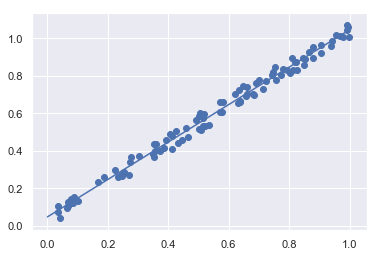

In [157]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

X = np.random.rand(100)
Y = X + np.random.rand(100)*0.1
# Ordinary least squares
results = sm.OLS(Y,sm.add_constant(X)).fit()

print (results.params)

plt.scatter(X,Y)

X_plot = np.linspace(0,1,100)
plt.plot(X_plot, X_plot*results.params[1] + results.params[0])

plt.show()

## Total Least Squares

### Problem with "vertical least squares"

- Not rotation-invariant
- Fails completely for vertical lines


[ 230.27188219 -229.85191635]


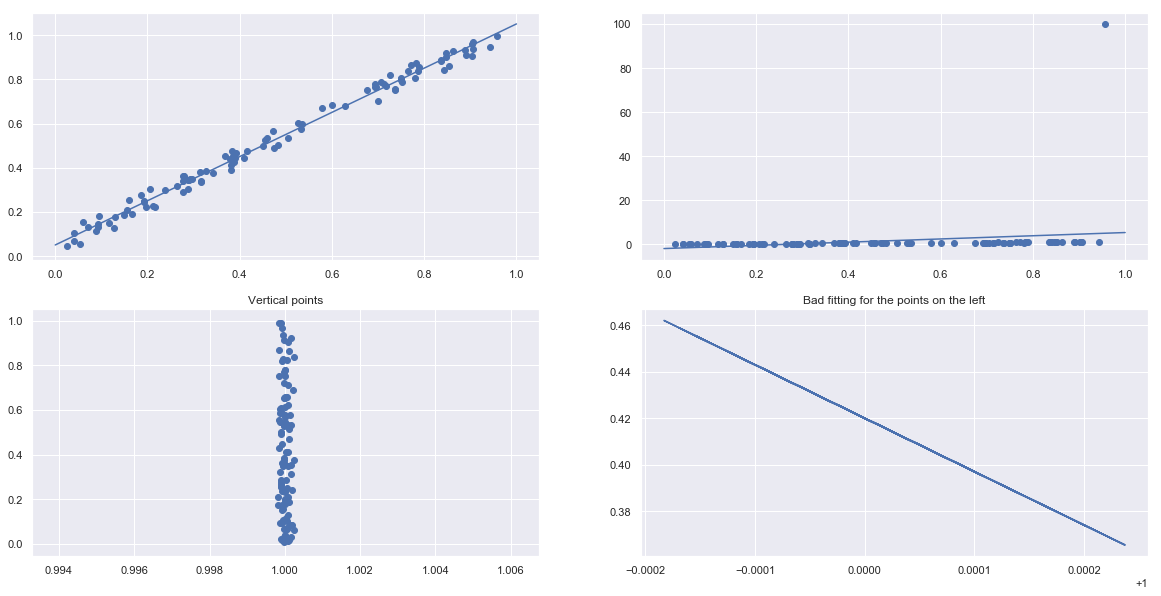

In [209]:
import matplotlib.pyplot as plt

X = np.random.rand(100)
Y = X + np.random.rand(100)*0.1
X_plot = np.linspace(0,1,100)

fig,ax = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches((20,10))

# Ordinary least squares
results = sm.OLS(Y,sm.add_constant(X)).fit()
ax[0,0].scatter(X,Y)
ax[0,0].plot(X_plot, X_plot*results.params[1] + results.params[0])

Y[np.argmax(X)] = 100
results = sm.OLS(Y,sm.add_constant(X)).fit()
ax[0,1].scatter(X,Y)
ax[0,1].plot(X_plot, X_plot*results.params[1] + results.params[0])

X = np.random.normal(1,0.0001,100)
Y = np.random.rand(100)
results = sm.OLS(Y,sm.add_constant(X)).fit()
print(results.params)
ax[1,0].set_title("Vertical points")
ax[1,0].scatter(X,Y)
ax[1,1].set_title("Bad fitting for the points on the left")
ax[1,1].plot(X, X*results.params[1] + results.params[0])


plt.show()

### Total least squares

<br />
<div class="container" style="width: 100%;">
<div class="sidebar" style="width: 260px; float: left;">

<br />
<br />
    
- Distance between point $(x_i,y_i)$ and line $ax+by=d$
- Find (a,b,d) to minimize the sum of squared <strong>perpendicular</strong> distances
<font color="blue">$$E = \sum_{i=1}^n{}(ax_i + by_i -d )^2$$</font>

    </div>
    <div class="content" style="margin-left: 202px;">
        <figure>
  <img src="imgs/tlsqrtf.png" width="300" />
  <center><figcaption>Fig.34</figcaption></center>
</figure>
    </div>
</div>

$$\frac{\partial E}{\partial d} = \sum_{i=1}^n{}-2(ax_i + by_i -d )=0$$
$$\implies d = \frac{a}{n}\sum_{i=1}^{n}x_i +\frac{b}{n}\sum_{i=1}^{n}x_i = a\bar{x}+b\bar{y}$$
$$E = \sum_{i=1}^{n}(a(x_i-\bar{x}) + b(y_i-\bar{y}))^2 = \left\vert\left\vert\begin{bmatrix}x_1-\bar{x}&y_1-\bar{y}\\.&.\\.&.\\.&.\\x_n-\bar{x}&y_n-\bar{y}\end{bmatrix}\begin{bmatrix}a\\b\end{bmatrix}\right\vert\right\vert^2 = (Uh)^T(Uh)$$

<font color="blue">$$\implies \frac{dE}{dh} = 2(U^TU)h = 0$$</font>

Solution to $(U^TU)h = 0$, subject to $||h||^2 = 1$: <br/>
&nbsp; &nbsp; eigenvector of $U^TU$ associated with the smalles eigenvalue (Again SVD to least squares solution to homogeneous linear system)

## Least squares as likelihood maximization

<br />
<div class="container" style="width: 100%;">
<div class="sidebar" style="width: 260px; float: left;">

    
- <font color="green">Generative</font> model: line points are currepted by Gaussian noise in the direction perpendicular to the line

$$\begin{bmatrix}x\\y\end{bmatrix}=\begin{bmatrix}u\\v\end{bmatrix}+\epsilon\begin{bmatrix}a\\b\end{bmatrix}$$

where 
- $\epsilon$: noise: sampled from zero-mean Gaussian with std. dev. $\sigma$
- $\begin{bmatrix}u\\v\end{bmatrix}$: point on the line
- $\begin{bmatrix}a\\b\end{bmatrix}$: normal direction

    </div>
    <div class="content" style="margin-left: 202px;">
        <figure>
  <img src="imgs/lsqrtl.png" width="300" />
  <center><figcaption>Fig.35</figcaption></center>
</figure>
    </div>
</div>




## Non Robustness to Non Gaussian Noise

### Least squres: Non-robustness to (very) non-Gaussian noise

<br />
<center>Least squares fit to the red points</center>
<figure>
  <img src="imgs/lsqrtlnrb.png" width="300" />
  <center><figcaption>Fig.36(a)</figcaption></center>
</figure>

<br />
<center>Least squares fit with an outlier</center>
<figure>
  <img src="imgs/lsqrtlnrb2.png" width="300" />
  <center><figcaption>Fig.36(b)</figcaption></center>
</figure>
    
Problem: squared error heavily penalizes outliers

## Robust Estimators

- General approach: minimize &nbsp; &nbsp;<font color="blue">$\sum_{i}\rho(r_i(x_i,\theta);\sigma)$</font>
- $r_i(x_i,\theta)$ - residual of $i^{th}$ point w.r.t. model parameters $\theta$
- $\rho$ - robust function with scale parameter $\sigma$

<div class="container" style="width: 100%;">
    <div class="sidebar" style="width: 300px; float: left;">
        <br />
<figure>
  <img src="imgs/robustestimator.png" />
  <center><figcaption>Fig.37(a)</figcaption></center>
</figure>
    </div>
    <div class="content" style="margin-left: 320px;">
        <br />
        <br />
        The Robust function $\rho$ behaves like squared distance for small values of the residual $u$ but saturates for larger values of $u$
    </div>
</div>


### Choosing the scale: Just right

<br />
<figure>
  <img src="imgs/robustestimator2.png" />
  <center><figcaption>Fig.37(b) The effect of the outlier is minimized </figcaption></center>
</figure>

### Choosing the scale: Too small

<br />
<figure>
  <img src="imgs/robustestimator3.png" />
  <center><figcaption>Fig.37(c) weird line</figcaption></center>
</figure>

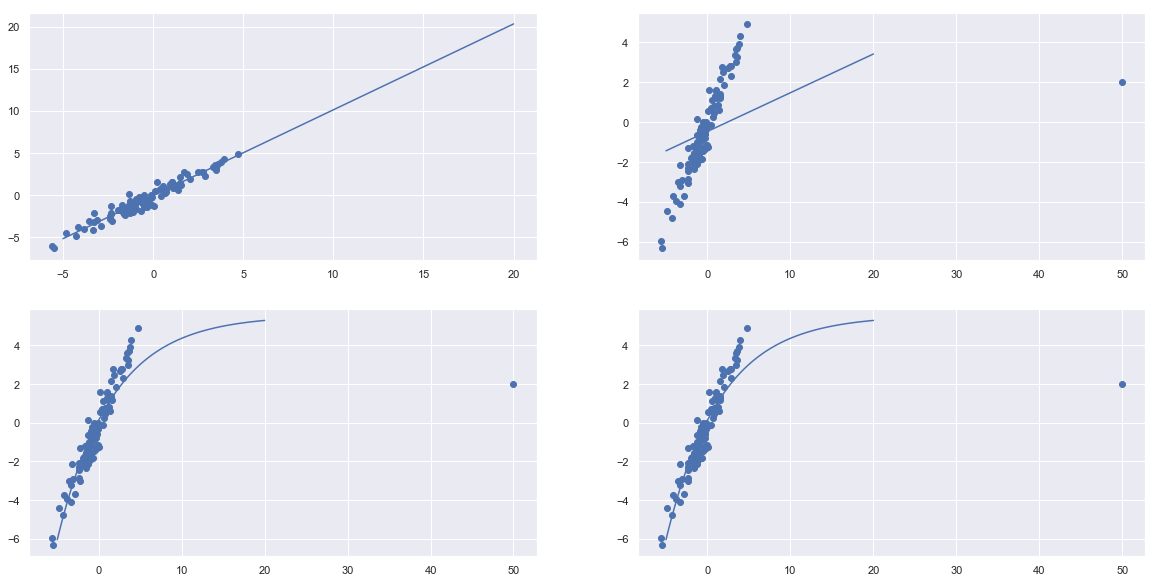

In [429]:
X = np.random.normal(0,2,100)
Y = X + np.random.normal(0,0.5,100)
X_plot = np.linspace(-5,20,100)

fig,ax = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches((20,10))

results = sm.OLS(Y,sm.add_constant(X)).fit()
ax[0,0].scatter(X,Y)
ax[0,0].plot(X_plot, X_plot*results.params[1] + results.params[0])


X[-1] = 50
Y[np.argmax(X)] = 2
results = sm.OLS(Y,sm.add_constant(X)).fit()
ax[0,1].scatter(X,Y)
ax[0,1].plot(X_plot, X_plot*results.params[1] + results.params[0])


def gen_data(t, a, b, c, noise=0, n_outliers=0, random_state=0):
    y = a + b * np.exp(t * c)
    
    rnd = np.random.RandomState(random_state)
    error = noise * rnd.randn(t.size)
    outliers = rnd.randint(0, t.size, n_outliers)
    error[outliers] *= 10
    
    return y + error


from scipy.optimize import least_squares
def fun(x, t, y):
    return x[0] + x[1] * np.exp(x[2] * t) - y

x0 = np.array([1, 1, 1])*0.90
res_lsq1 = least_squares(fun, x0, args=(X, Y))
y_lsq = gen_data(X_plot, *res_lsq1.x)
ax[1,0].scatter(X,Y)
ax[1,0].plot(X_plot, y_lsq)

x0 = np.array([1, 1, 1])*2
res_lsq2 = least_squares(fun, x0, args=(X, Y))
y_lsq = gen_data(X_plot, *res_lsq2.x)
ax[1,1].scatter(X,Y)
ax[1,1].plot(X_plot, y_lsq)




<div class="container" style="width: 100%;">
    <div class="sidebar" style="width: 200px; float: left;">
        <br />
<figure>
  <img src="imgs/robustestimator.png" />
  <center><figcaption>Fig.37</figcaption></center>
</figure>
    </div>
    <div class="content" style="margin-left: 202px;">
        The Robust function $\varrho$ behaves like squared distance for small values of the residual $u$ but saturates for larger values of $u$
    </div>
</div>

In [ ]:
<font color="green"></font>
<font color="blue"></font>

<br />
<figure>
  <img src="imgs/reco_under_occ.png" />
  <img src="imgs/reco_under_occ2.png" />
  <center><figcaption>Fig.28 Recognition example </figcaption></center>
</figure>